# make_B_mask
For https://github.com/ACCESS-NRI/access-om3-configs/issues/1010

Generates `B_mask.nc`, a mask for B-grid in places where sea ice forms in CICE based on 
- cells where sea ice has been present in simulations (in the Arctic, which has a more complex sea ice distribution)
- latitude (in the Antarctic, where the land affected by sea ice is south of 58S, apart from South Georgia)

## After running, move `~/B_mask.nc` to topog generation directory so it can be used in workflow
### Also run `finalise_B_mask.sh` to embed its provenance

In [1]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)
client

/proxy/8787/status


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46445,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46841,Total threads: 1
Dashboard: /proxy/34771/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:45549,


In [3]:
esm_file = "/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json"
datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=["variable"]
)

In [4]:
xh = datastore.search(variable="xh", frequency="fx").to_dask().xh
yh = datastore.search(variable="yh", frequency="fx").to_dask().yh

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [5]:
def fixcoords(da):
    da.coords["ni"] = xh.values
    da.coords["nj"] = yh.values
    da.coords["ni"].attrs = xh.attrs
    da.coords["nj"].attrs = yh.attrs
    da = da.rename(({"ni":"xh", "nj":"yh"}))
    return da

In [6]:
aice_ds = fixcoords(datastore.search(variable="aice_m", frequency="1mon").to_dask(
    xarray_open_kwargs = dict(chunks={"time": -1}, # Good for temporal operations, but not spatial
                              decode_timedelta=False)))
aice = aice_ds.aice_m

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [7]:
%%time
aice_max = aice.max("time").load()

CPU times: user 11.1 s, sys: 885 ms, total: 12 s
Wall time: 21.8 s


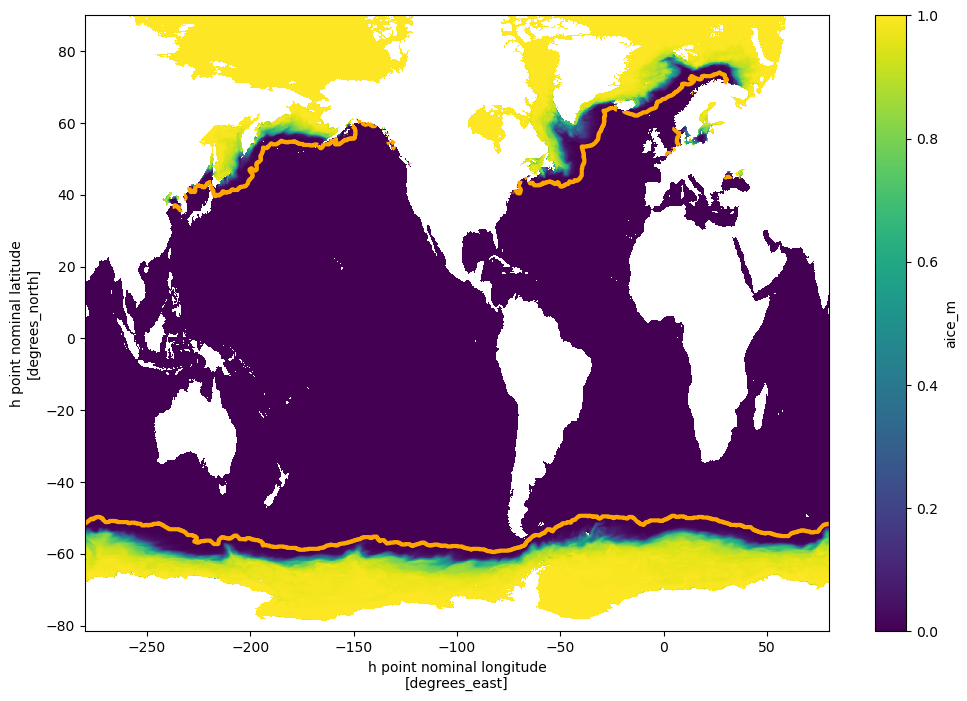

In [8]:
plt.figure(figsize=(12,8))
aice_max.plot()
plt.contour(aice_max.xh, aice_max.yh, aice_max, levels=[0], colors="orange", linewidths=3)

In [9]:
aice_max_nh = aice_max.copy(deep=True)
aice_max_nh[0:int(aice_max_nh.shape[0]/2), :] = 0.0  # remove SH ice

In [10]:
# Remove sea ice in North Sea, English Channel and mouth of Baltic - see map https://github.com/COSIMA/access-om2/issues/158#issuecomment-949224103
aice_max_nh.loc[{
    "xh": xh.sel(xh=slice(-10, 17)),
    "yh": yh.sel(yh=slice(0, 65))}] = 0.0

In [11]:
# Add ice in Tsugaru Strait to avoid the mask running through it
aice_max_nh.loc[{
    "xh": xh.sel(xh=slice(-221, -218)),
    "yh": yh.sel(yh=slice(40, 42))}] = 1.0

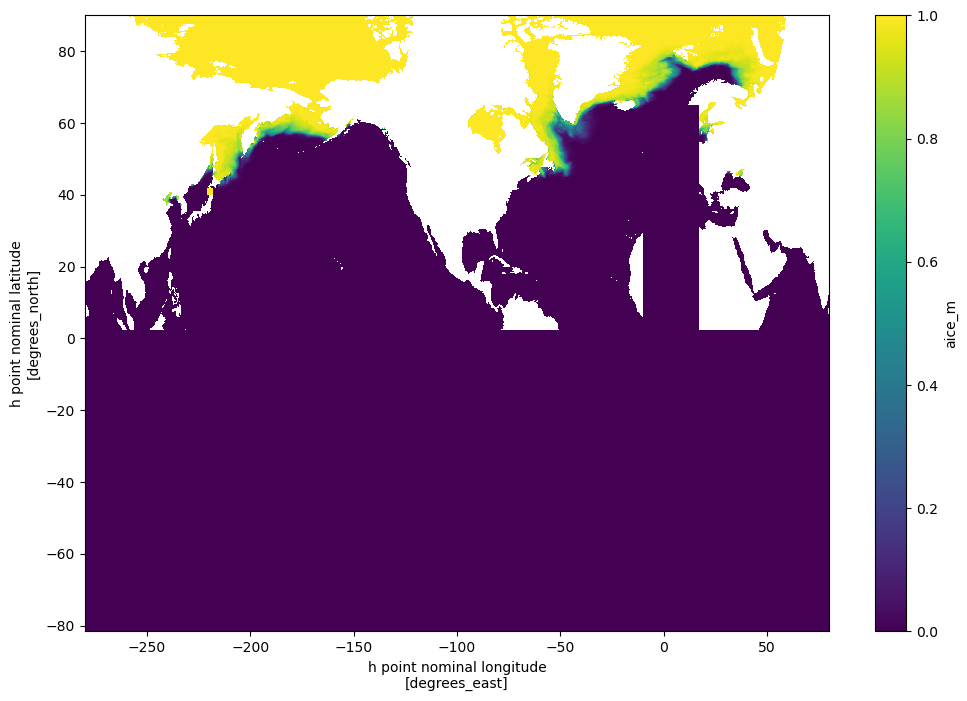

In [12]:
plt.figure(figsize=(12,8))
aice_max_nh.plot()

In [13]:
aice_thesh = 0
lat_offset = -1
mask_yh = ( # y value of mask based on lowest NH latitude where ice may be present, with offset and rolling min
                aice_max_nh.yh.where(
                    aice_max_nh > aice_thesh,
                ).min(dim="yh")
          ).rolling( # to get a smoother line
              xh=25,
              min_periods=1,
              center=False  # to get what we want in Baltic
          ).min().fillna(aice_max_nh.yh[-1]) + lat_offset

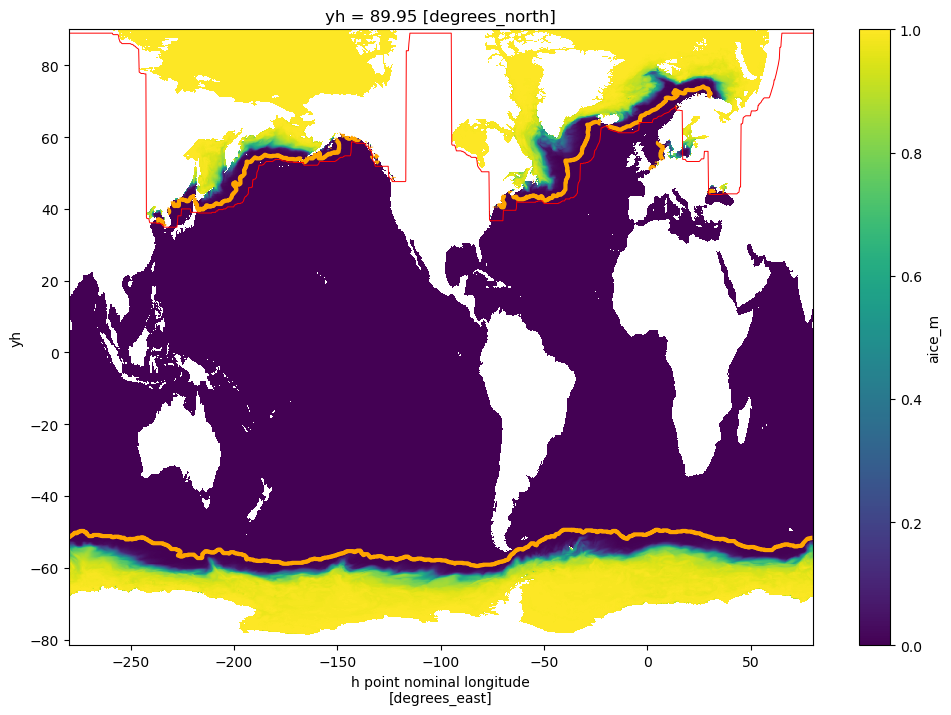

In [14]:
plt.figure(figsize=(12,8))
aice_max.plot()
plt.contour(aice_max.xh, aice_max.yh, aice_max, levels=[aice_thesh], colors="orange", linewidths=3)
mask_yh.plot(linewidth=0.7, color="red")

In [15]:
# define B_mask = 0 for C-grid (ice-free), 1 for B-grid
B_mask = 0 * aice_ds.isel(time=0, drop=True).astype('byte').fillna(0).load()
B_mask = B_mask.rename({"aice_m": "B_mask"})
B_mask = 1 - B_mask.where(B_mask.yh > mask_yh, 1) * B_mask.where(B_mask.yh < -58, 1)
B_mask.B_mask.loc[{"xh": xh.sel(xh=slice(-50, -25)),
                   "yh": yh.sel(yh=slice(-90, -45))}] = 1  # for South Georgia and South Sandwich islands
B_mask.B_mask.attrs = {"long_name": 
                       "Mask for coastal cells at which to apply B-grid fixes with topogtools fix_nonadvective --coastal-cells for C-grid MOM6 coupled to B-grid CICE6; B_mask = 0 for C-grid (ice-free), 1 for B-grid (sea ice may be present)"}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.11/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, 

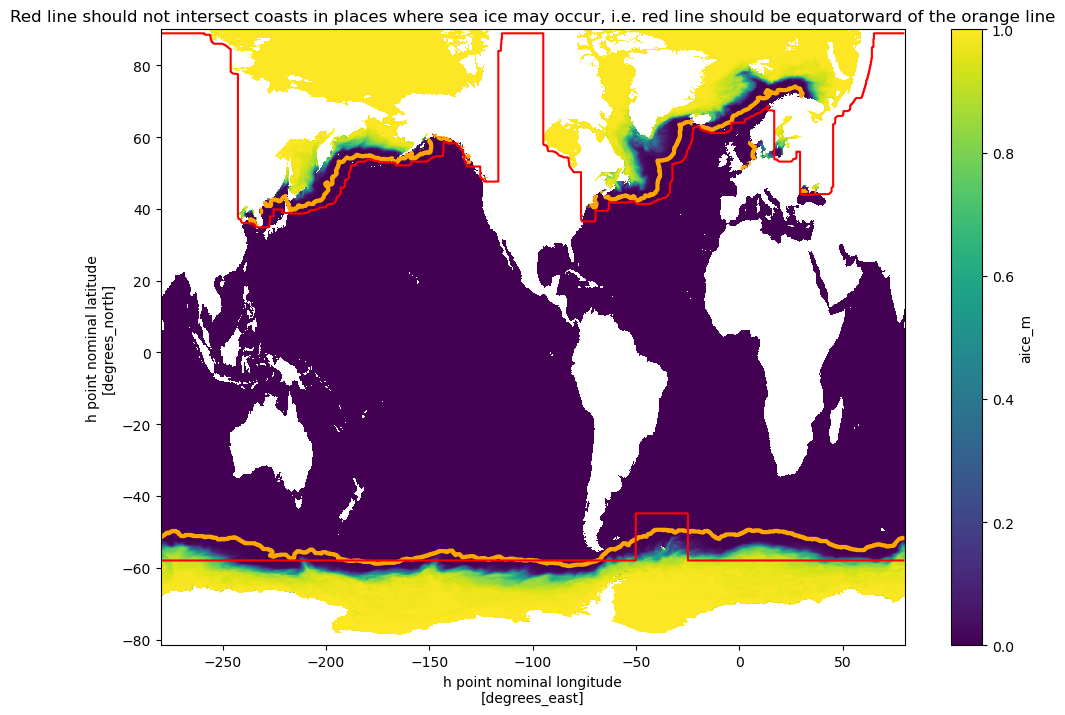

In [16]:
plt.figure(figsize=(12,8))
aice_max.plot()
plt.contour(aice_max.xh, aice_max.yh, aice_max, levels=[0], colors="orange", linewidths=3)
plt.contour(B_mask.xh, B_mask.yh, B_mask.B_mask, levels=[0], colors="red")
plt.title("Red line should not intersect coasts in places where sea ice may occur, i.e. red line should be equatorward of the orange line");

In [17]:
# Set dimension names to match topog.nc
B_mask = B_mask.drop(["xh", "yh"])
B_mask = B_mask.rename({"xh": "nx", "yh": "ny"})
B_mask

/jobfs/159781430.gadi-pbs/ipykernel_186749/1793811875.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  B_mask = B_mask.drop(["xh", "yh"])


<xarray.Dataset> Size: 2MB
Dimensions:  (ny: 1152, nx: 1440)
Dimensions without coordinates: ny, nx
Data variables:
    B_mask   (ny, nx) int8 2MB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1

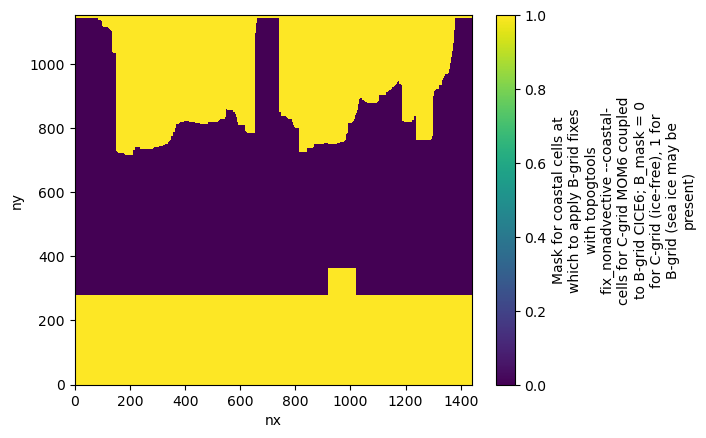

In [18]:
B_mask.B_mask.plot()

In [19]:
B_mask.to_netcdf("B_mask.nc", encoding={"B_mask": {"zlib": True, "complevel": 9}})

# Need to move `~/B_mask.nc` to topog generation directory so it can be used in workflow!
## Also run `finalise_B_mask.sh` to embed its provenance